In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
!pip install xgboost
import xgboost as xgb




In [2]:
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [3]:
df=pd.read_csv("/content/sample_data/bank-additional-full.csv",sep=';')

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.drop(df[(df["duration"]==0)].index,inplace=True)

In [6]:
df["pdays"] = df["pdays"].apply(lambda x: 0 if x == 999 else 1)


In [7]:
df.previous = df.previous.apply(lambda x: 1 if x > 0 else 0)

In [8]:
numeric_cols = df.select_dtypes(include=["float64","int64"])

In [9]:
numeric_cols.drop(["pdays","previous"],axis=1,inplace=True)

In [10]:
def OTH(df,col_name, low_quantile=0.25,up_quantile=0.75):
    Q1=df[col_name].quantile(low_quantile)
    Q3=df[col_name].quantile(up_quantile)
    IQR=Q3-Q1
    low_limit=Q1-1.5*IQR
    up_limit=Q3+1.5*IQR
    print(col_name,low_limit,up_limit)
    return low_limit,up_limit


In [11]:
def replace(dataframe,variables):
    low_limit, up_limit= OTH(dataframe,variables)
    dataframe.loc[(dataframe[variables]<low_limit),variables]=low_limit
    dataframe.loc[(dataframe[variables]>up_limit),variables]=up_limit

In [12]:
for col in numeric_cols:
    print(col,replace(df,col))


age 9.5 69.5
age None
duration -223.5 644.5
duration None
campaign -2.0 6.0
campaign None
emp.var.rate -6.6000000000000005 6.200000000000001
emp.var.rate None
cons.price.idx 91.69650000000001 95.3725
cons.price.idx None
cons.conf.idx -52.150000000000006 -26.949999999999992
cons.conf.idx None
euribor3m -4.081499999999999 10.3865
euribor3m None
nr.employed 4905.6 5421.6
nr.employed None


<ipython-input-11-703c54c727bd>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variables]<low_limit),variables]=low_limit
<ipython-input-11-703c54c727bd>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-223.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variables]<low_limit),variables]=low_limit


In [13]:
df["emp.var.rate*nr.employed*euribor3m"]=df["emp.var.rate"]*df["nr.employed"]*df["euribor3m"]

In [14]:
df.drop(["emp.var.rate","euribor3m","nr.employed"],axis=1,inplace=True)

In [15]:
num_cols=(df.select_dtypes(["int64","float64"]))

<Axes: >

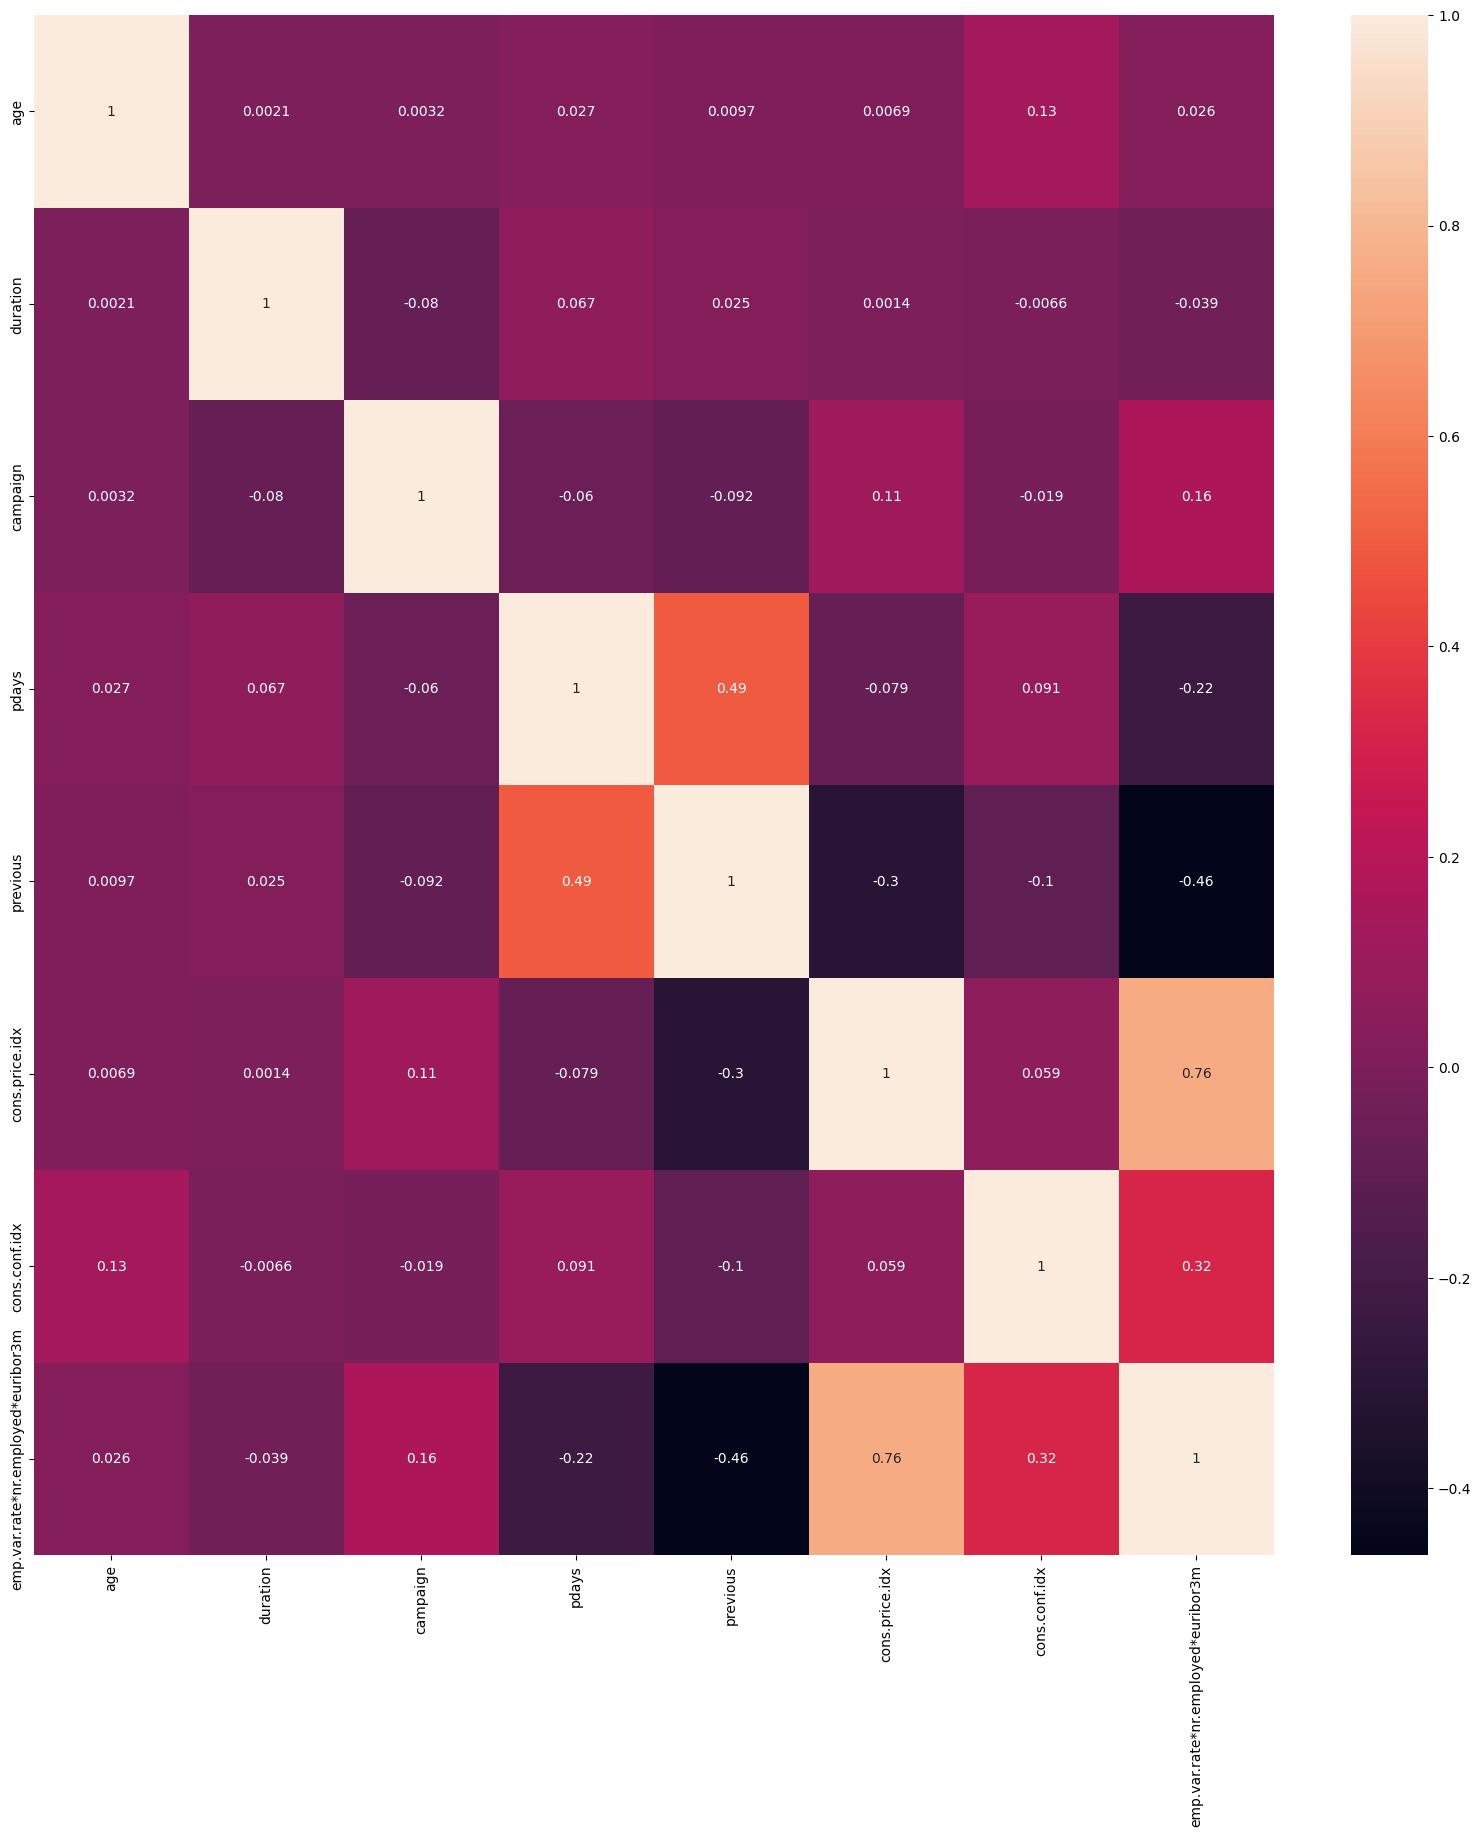

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(df[list(num_cols)].corr(),annot=True)

In [17]:
df[["job","marital","loan","default","housing","education"]]=df[["job","marital","loan","default","housing","education"]].replace("unknown",np.NaN)

In [18]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


categorical_cols = df.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))


imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)
df_clean_imputed = imputer.fit_transform(df)

df_clean_imputed = pd.DataFrame(df_clean_imputed, columns=df.columns)
print(df_clean_imputed.head())


    age  job  marital  education  default  housing  loan  contact  month  \
0  56.0  3.0      1.0        0.0      1.0      1.0   1.0      1.0    6.0   
1  57.0  8.0      1.0        3.0      0.0      1.0   1.0      1.0    6.0   
2  37.0  8.0      1.0        3.0      1.0      2.0   1.0      1.0    6.0   
3  40.0  0.0      1.0        1.0      1.0      1.0   1.0      1.0    6.0   
4  56.0  8.0      1.0        3.0      1.0      1.0   2.0      1.0    6.0   

   day_of_week  duration  campaign  pdays  previous  poutcome  cons.price.idx  \
0          1.0     261.0       1.0    0.0       0.0       1.0          93.994   
1          1.0     149.0       1.0    0.0       0.0       1.0          93.994   
2          1.0     226.0       1.0    0.0       0.0       1.0          93.994   
3          1.0     151.0       1.0    0.0       0.0       1.0          93.994   
4          1.0     307.0       1.0    0.0       0.0       1.0          93.994   

   cons.conf.idx    y  emp.var.rate*nr.employed*euribor3

In [19]:
df=df_clean_imputed

In [20]:
X=df.drop("y",axis=1)
y=df["y"]

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [22]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [23]:
from collections import Counter

class_counts = Counter(y_train)
total_samples = len(y_train)

weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("Sınıf Ağırlıkları:", weights)

Sınıf Ağırlıkları: {0.0: 1.1263593461459545, 1.0: 8.913937753721244}


# **Models**

**Svm-Weight Class**

Accuracy: 0.8413

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7291
         1.0       0.41      0.92      0.57       944

    accuracy                           0.84      8235
   macro avg       0.70      0.88      0.74      8235
weighted avg       0.92      0.84      0.86      8235


Confusion Matrix:
[[6059 1232]
 [  75  869]]


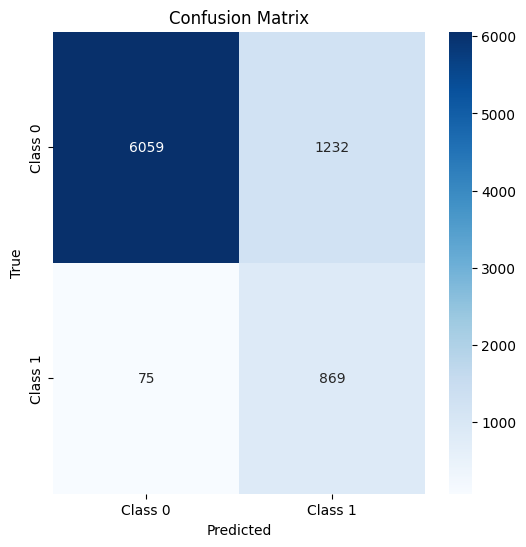

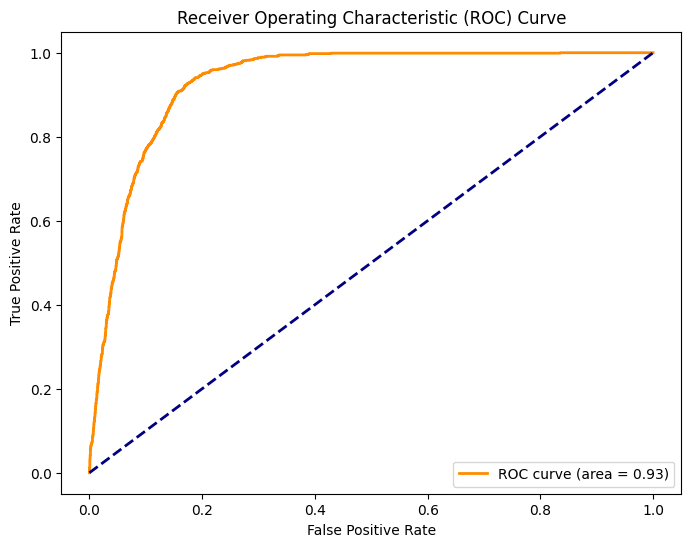


Tuned Model Accuracy: 0.8557

Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      7291
         1.0       0.43      0.83      0.57       944

    accuracy                           0.86      8235
   macro avg       0.70      0.84      0.74      8235
weighted avg       0.91      0.86      0.87      8235


Tuned Confusion Matrix:
[[6264 1027]
 [ 161  783]]


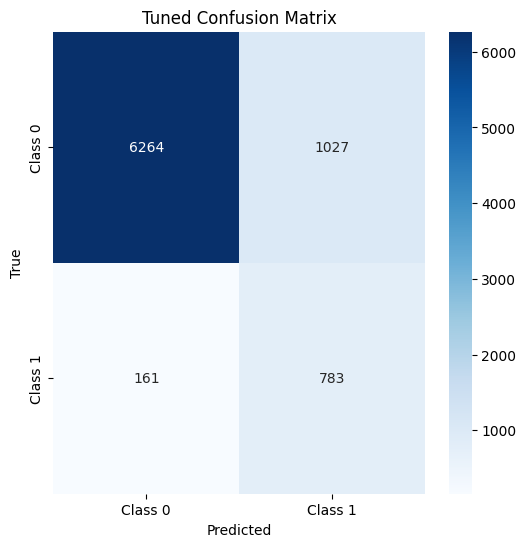

In [24]:

clf = SVC(class_weight={0: weights[0], 1: weights[1]}, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

clf_tuned = SVC(class_weight={0: weights[0], 1: weights[1]}, C=10, kernel='rbf', random_state=42)
clf_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = clf_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Svm-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: [29242 29242]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.84      0.91      7291
         1.0       0.42      0.90      0.57       944

    accuracy                           0.85      8235
   macro avg       0.70      0.87      0.74      8235
weighted avg       0.92      0.85      0.87      8235

Confusion Matrix:
 [[6114 1177]
 [  95  849]]
ROC AUC Score: 0.930623342221313


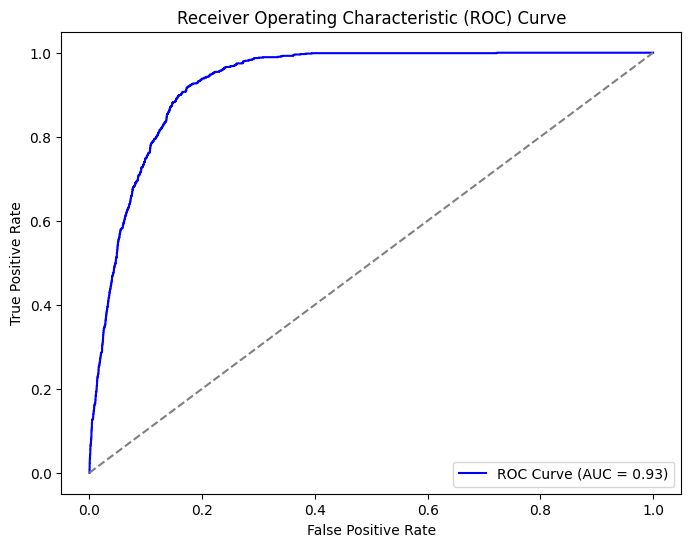

In [25]:

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution after SMOTE: {np.bincount(y_resampled)}")

svm_clf = SVC(kernel='rbf',class_weight="balanced", C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_resampled, y_resampled)

y_pred = svm_clf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_prob = svm_clf.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Svm-BaggingClassifier**

In [26]:

from sklearn.ensemble import BaggingClassifier


svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)

ensemble_svm = BaggingClassifier(estimator=svm_clf, n_estimators=10, random_state=42)

ensemble_svm.fit(X_train_scaled, y_train)

y_pred = ensemble_svm.predict(X_test_scaled)


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[6083 1208]
 [  81  863]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7291
         1.0       0.42      0.91      0.57       944

    accuracy                           0.84      8235
   macro avg       0.70      0.87      0.74      8235
weighted avg       0.92      0.84      0.87      8235



**Svm-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[5964 1327]
 [  69  875]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90      7291
         1.0       0.40      0.93      0.56       944

    accuracy                           0.83      8235
   macro avg       0.69      0.87      0.73      8235
weighted avg       0.92      0.83      0.86      8235


ROC AUC Score: 0.93


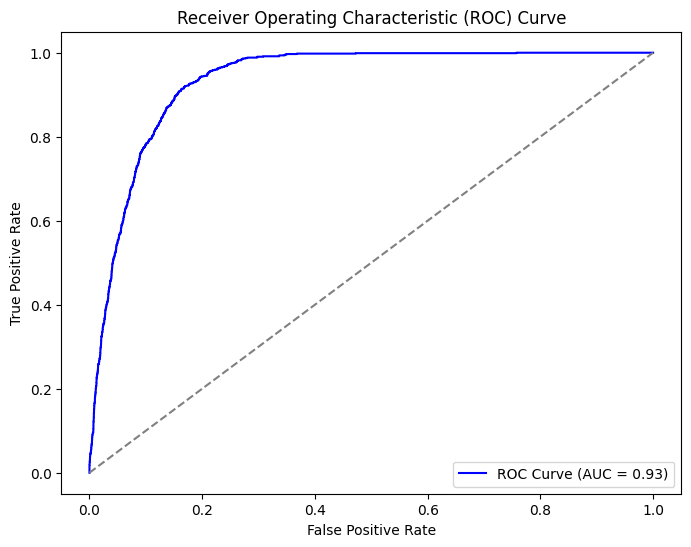

In [27]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Svm-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTE+ENN sonrası sınıf dağılımı: [24282 28537]

Confusion Matrix:
[[5954 1337]
 [  63  881]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89      7291
         1.0       0.40      0.93      0.56       944

    accuracy                           0.83      8235
   macro avg       0.69      0.87      0.73      8235
weighted avg       0.92      0.83      0.86      8235


ROC AUC Score: 0.93


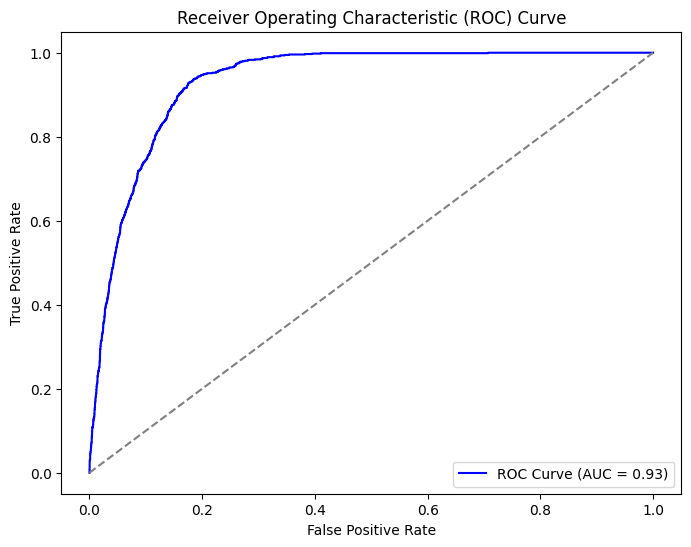

In [28]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE+ENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-Weight Class**

Accuracy: 0.8417

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90      7291
         1.0       0.41      0.89      0.56       944

    accuracy                           0.84      8235
   macro avg       0.70      0.86      0.73      8235
weighted avg       0.92      0.84      0.86      8235


Confusion Matrix:
[[6094 1197]
 [ 107  837]]


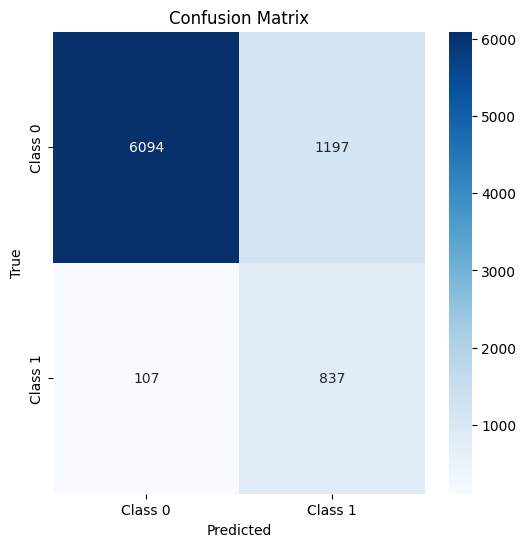

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


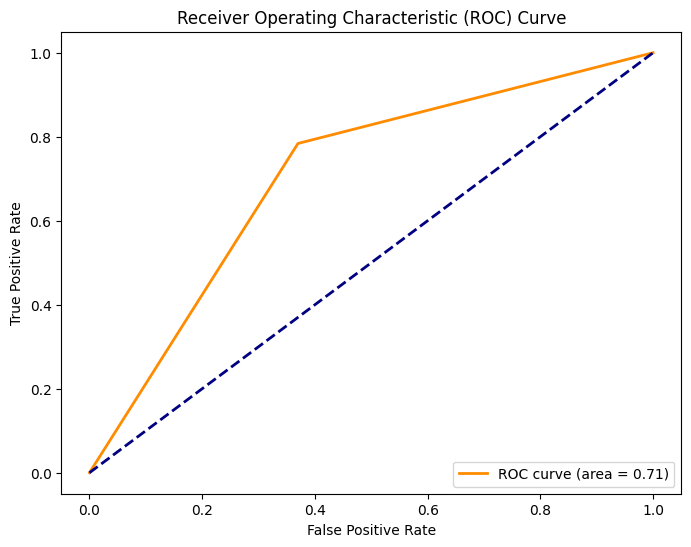


Tuned Model Accuracy: 0.8419

Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90      7291
         1.0       0.41      0.89      0.56       944

    accuracy                           0.84      8235
   macro avg       0.70      0.86      0.73      8235
weighted avg       0.92      0.84      0.86      8235


Tuned Confusion Matrix:
[[6096 1195]
 [ 107  837]]


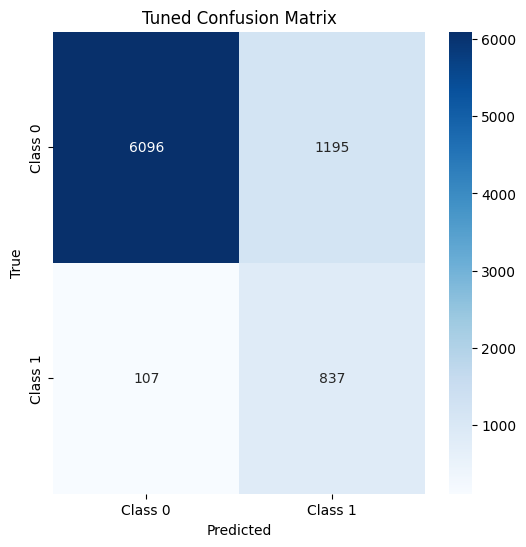

In [29]:

log_reg = LogisticRegression(class_weight={0: weights[0], 1: weights[1]}, random_state=42, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

log_reg_tuned = LogisticRegression(class_weight={0:weights[0], 1: weights[1] }, random_state=42, C=10, solver='liblinear')
log_reg_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = log_reg_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Logistic Regression-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6124 1167]
 [ 112  832]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.91      7291
         1.0       0.42      0.88      0.57       944

    accuracy                           0.84      8235
   macro avg       0.70      0.86      0.74      8235
weighted avg       0.92      0.84      0.87      8235


ROC AUC Score: 0.93


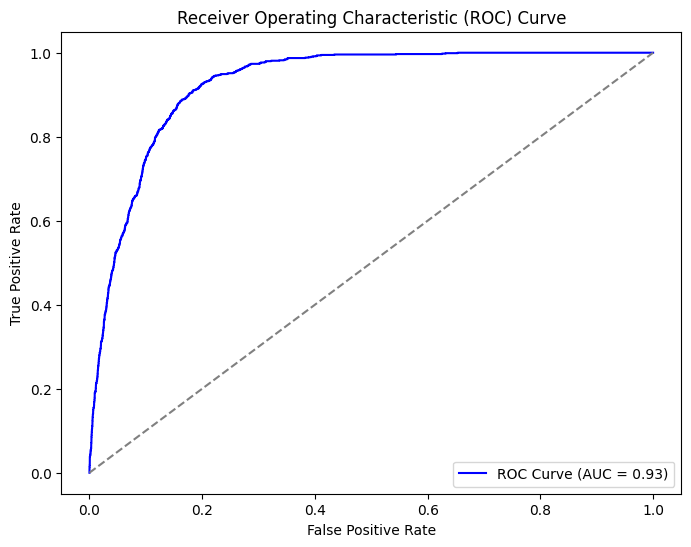

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(class_weight="balanced",solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



**Logistic Regression-Bagging Classifier**


Confusion Matrix:
[[6027 1264]
 [ 122  822]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      7291
         1.0       0.39      0.87      0.54       944

    accuracy                           0.83      8235
   macro avg       0.69      0.85      0.72      8235
weighted avg       0.91      0.83      0.86      8235


ROC AUC Score: 0.92


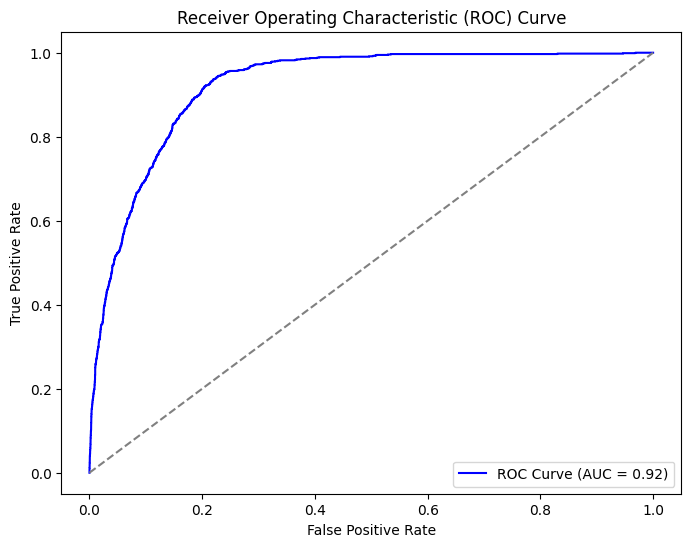

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve




base_model = LogisticRegression(class_weight={0:weights[0], 1: weights[1] },solver='liblinear', random_state=42)
ensemble_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    random_state=42,
    max_samples=0.8,
    max_features=0.8
)

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)
y_prob = ensemble_model.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6088 1203]
 [ 109  835]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90      7291
         1.0       0.41      0.88      0.56       944

    accuracy                           0.84      8235
   macro avg       0.70      0.86      0.73      8235
weighted avg       0.92      0.84      0.86      8235


ROC AUC Score: 0.93


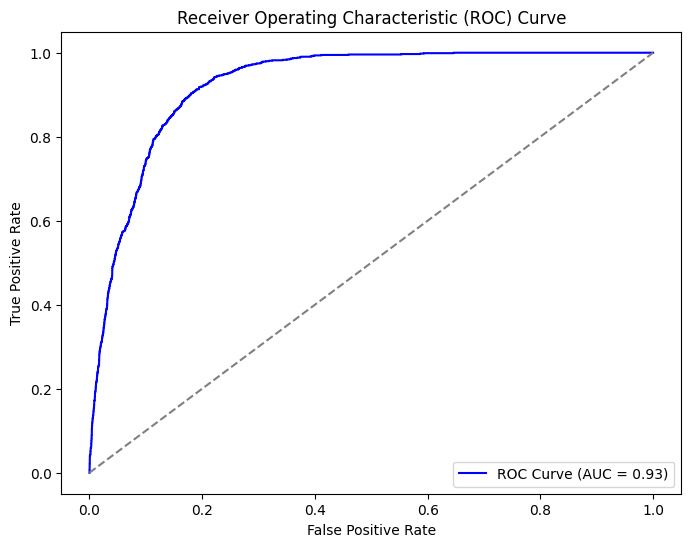

In [32]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [24282 28537]

Confusion Matrix:
[[5814 1477]
 [  72  872]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88      7291
         1.0       0.37      0.92      0.53       944

    accuracy                           0.81      8235
   macro avg       0.68      0.86      0.71      8235
weighted avg       0.92      0.81      0.84      8235


ROC AUC Score: 0.93


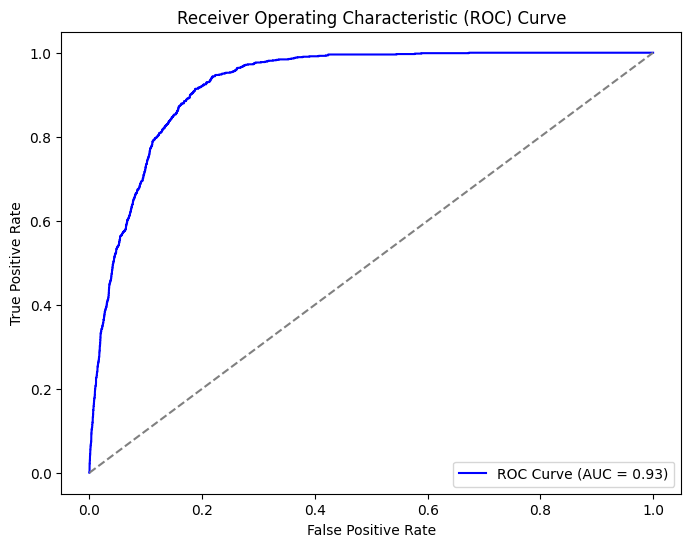

In [33]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Weight Class**

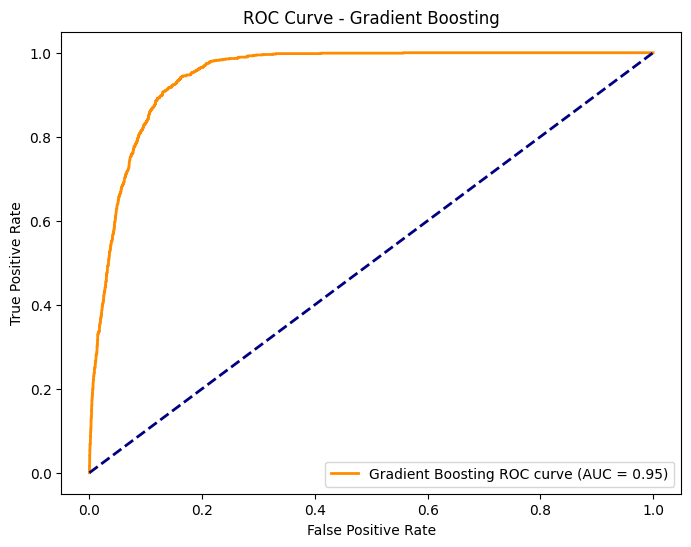


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7291
         1.0       0.44      0.93      0.60       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.88      8235



In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report


gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

sample_weights = [weights[1] if label == 1 else weights[0]  for label in y_train]

gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_prob_gb = gb.predict_proba(X_test_scaled)[:, 1]

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='Gradient Boosting ROC curve (AUC = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, gb.predict(X_test_scaled)))


**GradientBoost-Smote**

Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Confusion Matrix:
[[6495  796]
 [ 145  799]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      7291
         1.0       0.50      0.85      0.63       944

    accuracy                           0.89      8235
   macro avg       0.74      0.87      0.78      8235
weighted avg       0.92      0.89      0.90      8235


ROC AUC Score: 0.94


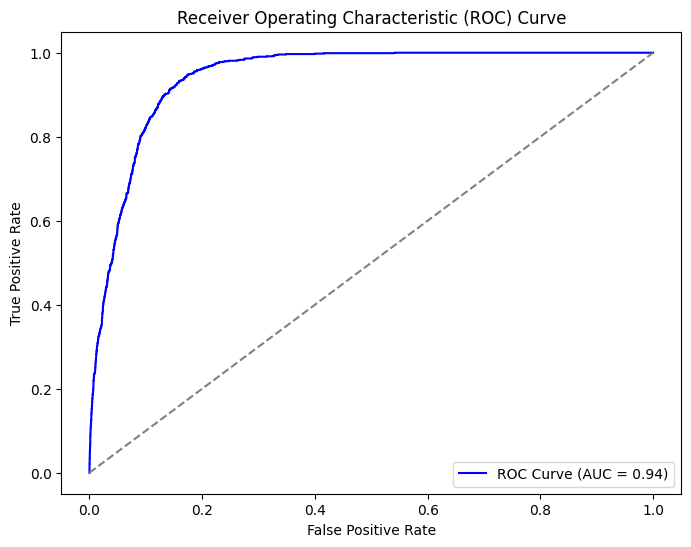

In [35]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6135 1156]
 [  65  879]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      7291
         1.0       0.43      0.93      0.59       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.87      8235


ROC AUC Score: 0.94


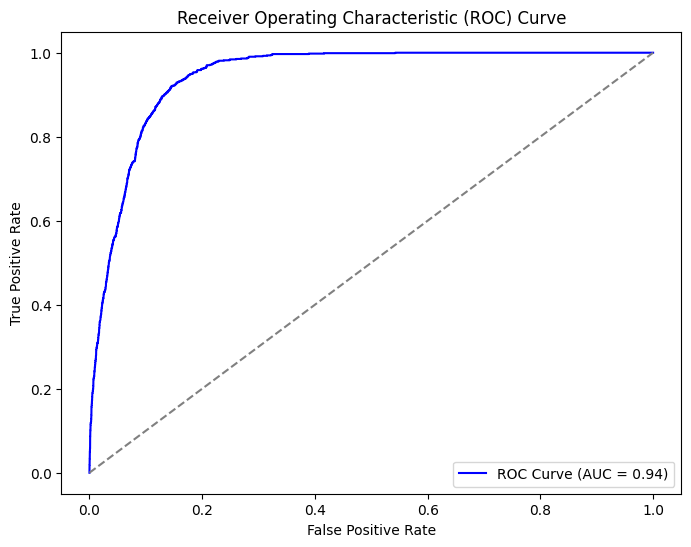

In [36]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Smoteen**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [24332 28537]

Confusion Matrix:
[[6152 1139]
 [  68  876]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      7291
         1.0       0.43      0.93      0.59       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.87      8235


ROC AUC Score: 0.94


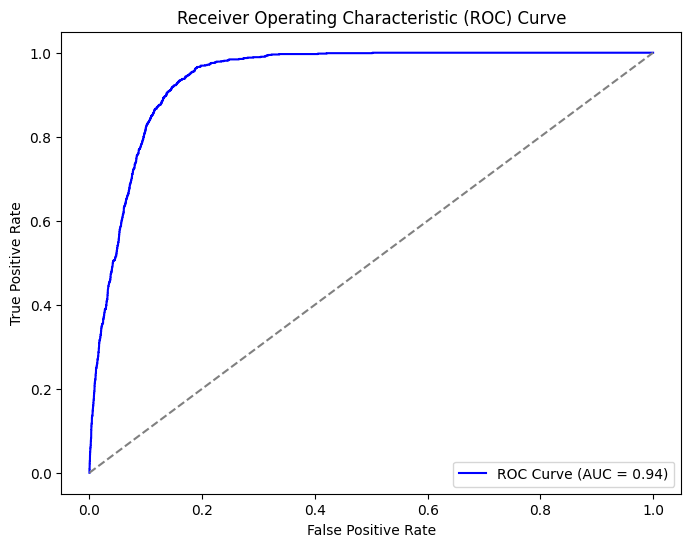

In [ ]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Catboost-Weight Class**

Accuracy: 0.8820

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7291
         1.0       0.49      0.90      0.64       944

    accuracy                           0.88      8235
   macro avg       0.74      0.89      0.78      8235
weighted avg       0.93      0.88      0.90      8235


Confusion Matrix:
[[6415  876]
 [  96  848]]


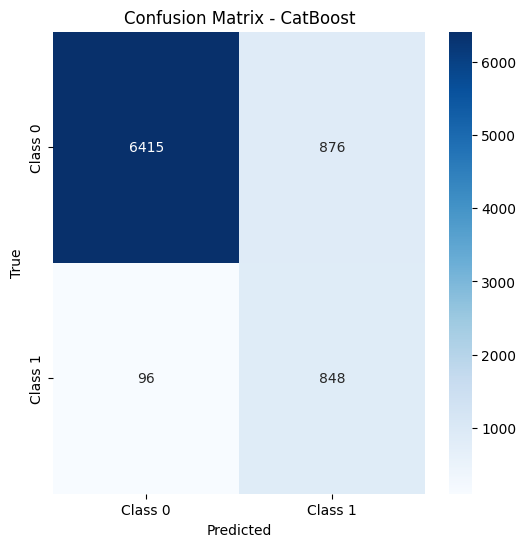

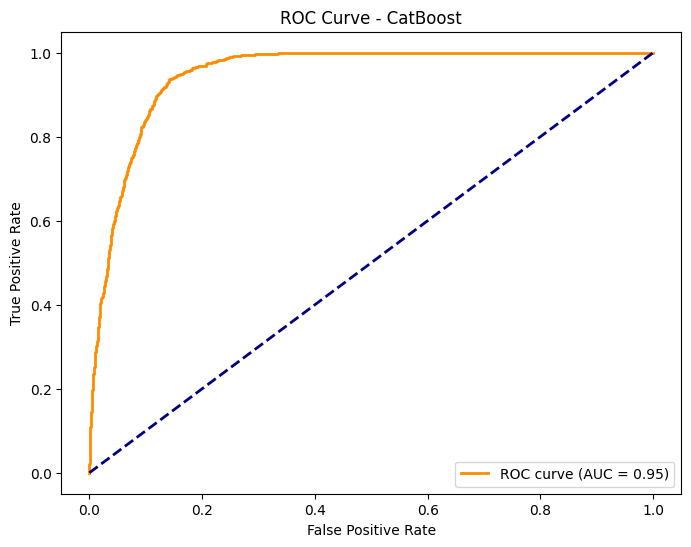

In [37]:


catboost_model = CatBoostClassifier(iterations=1000, class_weights=[weights[0],weights[1]], random_state=42, verbose=0)

catboost_model.fit(X_train_scaled, y_train)

y_pred_catboost = catboost_model.predict(X_test_scaled)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"Accuracy: {accuracy_catboost:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_catboost))

conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
print("\nConfusion Matrix:")
print(conf_matrix_catboost)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
y_prob_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]

fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_prob_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_catboost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6969  322]
 [ 411  533]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      7291
         1.0       0.62      0.56      0.59       944

    accuracy                           0.91      8235
   macro avg       0.78      0.76      0.77      8235
weighted avg       0.91      0.91      0.91      8235


ROC AUC Score: 0.95


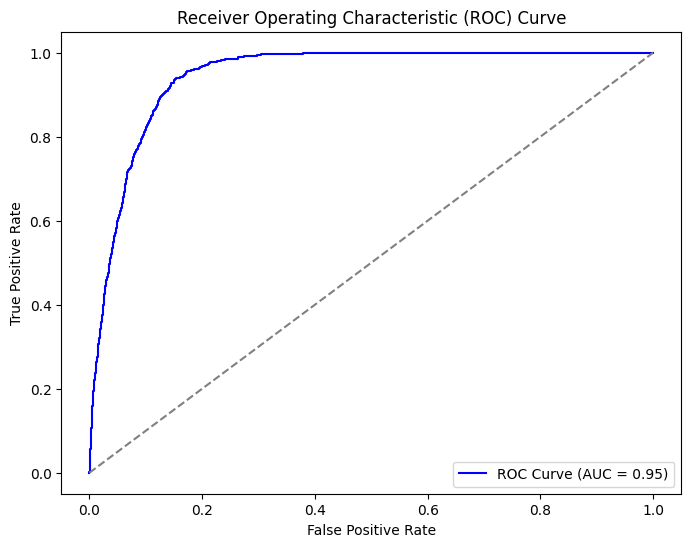

In [38]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6228 1063]
 [  71  873]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      7291
         1.0       0.45      0.92      0.61       944

    accuracy                           0.86      8235
   macro avg       0.72      0.89      0.76      8235
weighted avg       0.93      0.86      0.88      8235


ROC AUC Score: 0.94


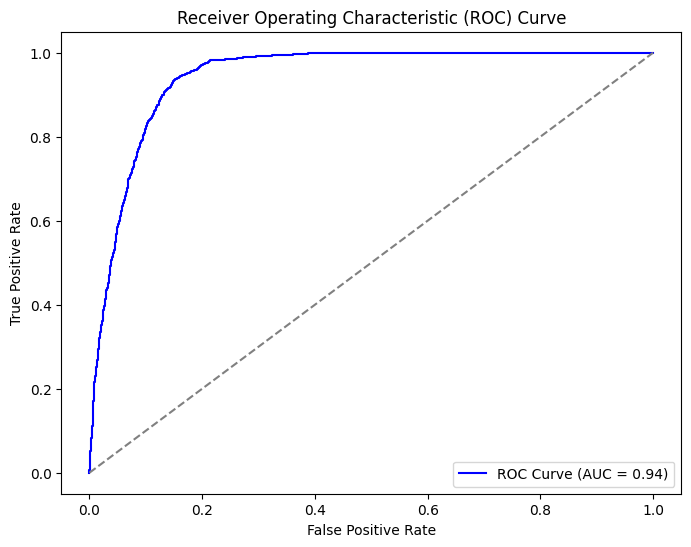

In [39]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [24282 28537]

Confusion Matrix:
[[6467  824]
 [ 127  817]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      7291
         1.0       0.50      0.87      0.63       944

    accuracy                           0.88      8235
   macro avg       0.74      0.88      0.78      8235
weighted avg       0.93      0.88      0.90      8235


ROC AUC Score: 0.95


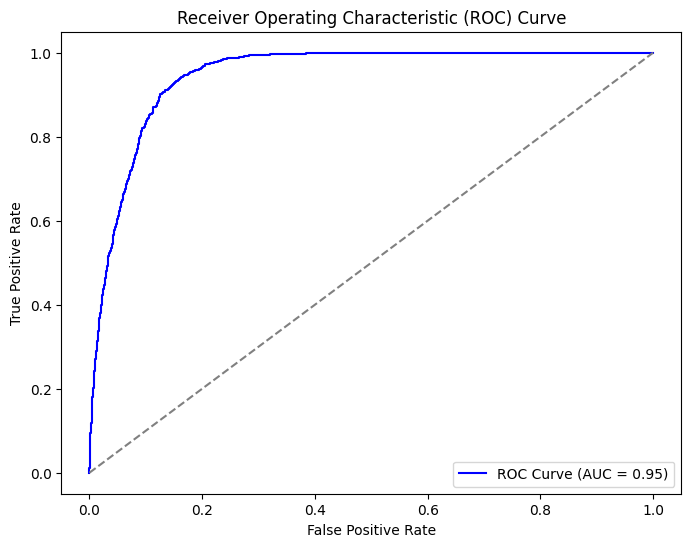

In [40]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Weight Class**


Confusion Matrix:
[[6279 1012]
 [  75  869]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      7291
         1.0       0.46      0.92      0.62       944

    accuracy                           0.87      8235
   macro avg       0.73      0.89      0.77      8235
weighted avg       0.93      0.87      0.89      8235


ROC AUC Score: 0.95


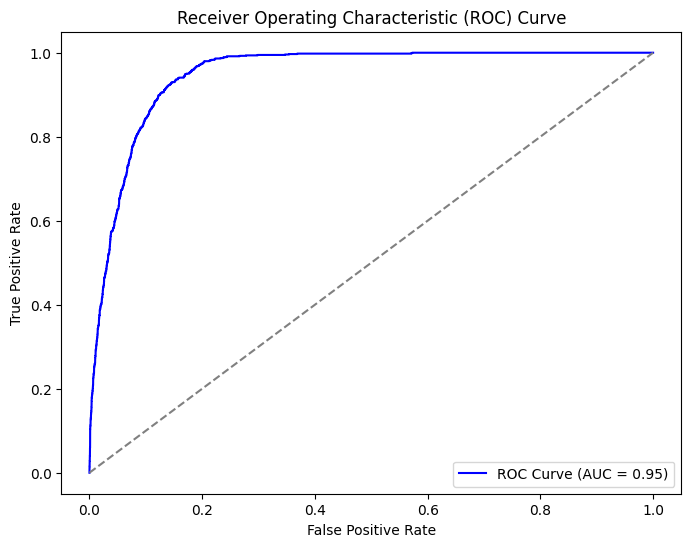

In [41]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_train_scaled, y_train)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6758  533]
 [ 262  682]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      7291
         1.0       0.56      0.72      0.63       944

    accuracy                           0.90      8235
   macro avg       0.76      0.82      0.79      8235
weighted avg       0.92      0.90      0.91      8235


ROC AUC Score: 0.95


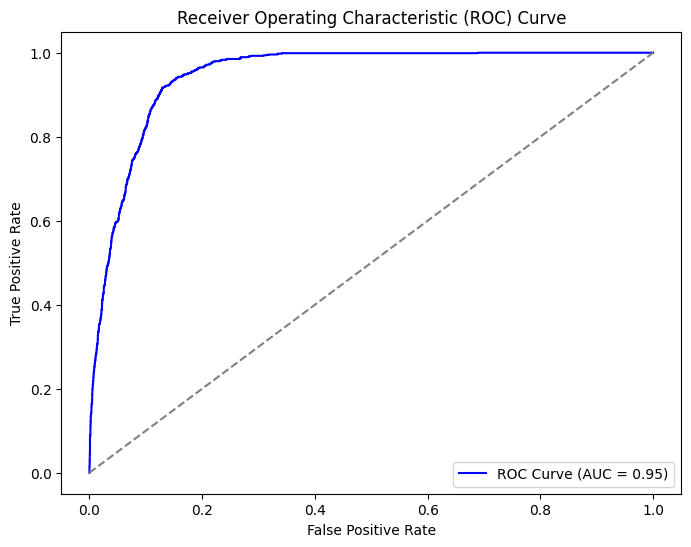

In [42]:



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6189 1102]
 [  55  889]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      7291
         1.0       0.45      0.94      0.61       944

    accuracy                           0.86      8235
   macro avg       0.72      0.90      0.76      8235
weighted avg       0.93      0.86      0.88      8235


ROC AUC Score: 0.95


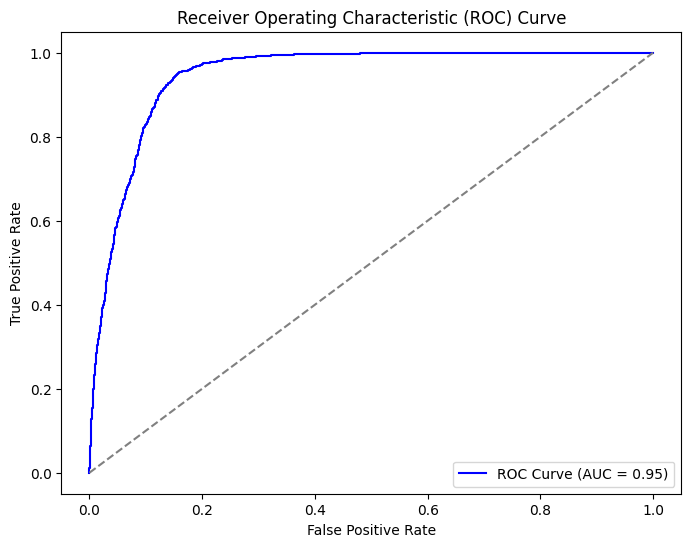

In [43]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**XgBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [24282 28537]

Confusion Matrix:
[[6334  957]
 [  86  858]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      7291
         1.0       0.47      0.91      0.62       944

    accuracy                           0.87      8235
   macro avg       0.73      0.89      0.77      8235
weighted avg       0.93      0.87      0.89      8235


ROC AUC Score: 0.94


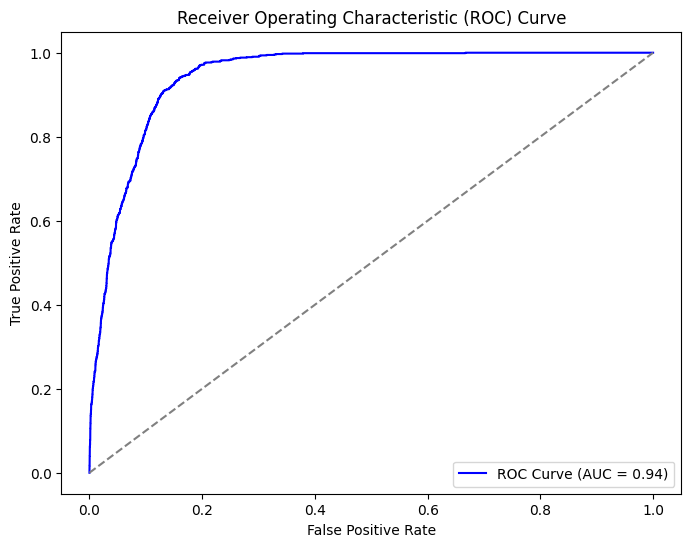

In [44]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
  random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Weight Class**


Confusion Matrix:
[[7088  203]
 [ 524  420]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7291
         1.0       0.67      0.44      0.54       944

    accuracy                           0.91      8235
   macro avg       0.80      0.71      0.74      8235
weighted avg       0.90      0.91      0.90      8235


ROC AUC Score: 0.94


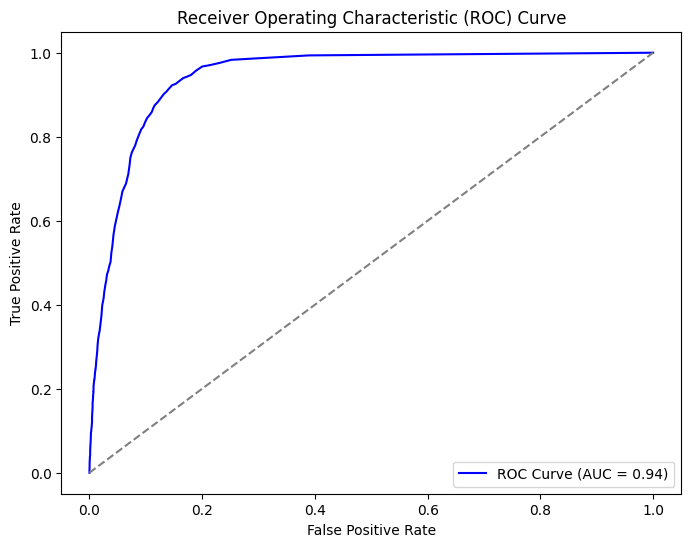

In [45]:


random_forest_clf = RandomForestClassifier(
    class_weight={0: weights[0],1: weights[1] },
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_train_scaled, y_train)

y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6846  445]
 [ 326  618]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95      7291
         1.0       0.58      0.65      0.62       944

    accuracy                           0.91      8235
   macro avg       0.77      0.80      0.78      8235
weighted avg       0.91      0.91      0.91      8235


ROC AUC Score: 0.94


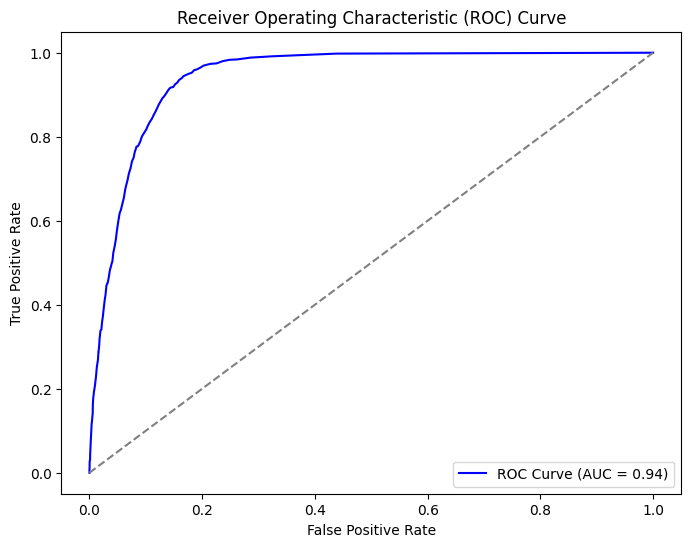

In [46]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_resampled, y_resampled)


y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6144 1147]
 [  65  879]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      7291
         1.0       0.43      0.93      0.59       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.87      8235


ROC AUC Score: 0.94


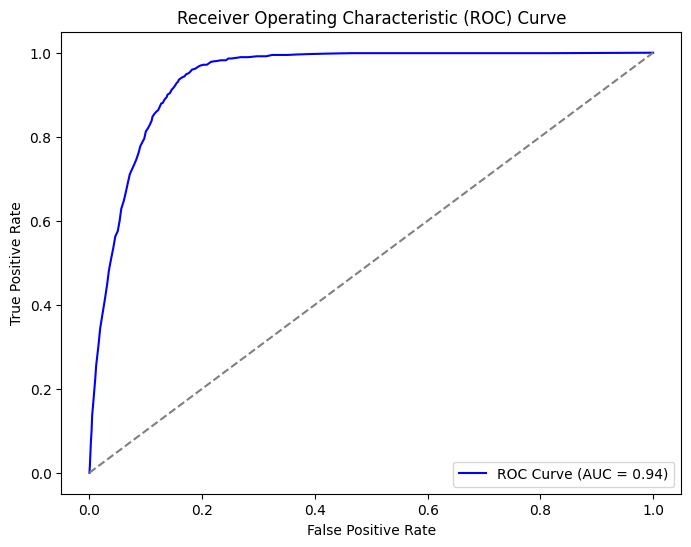

In [48]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [24282 28537]

Confusion Matrix:
[[6356  935]
 [ 100  844]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      7291
         1.0       0.47      0.89      0.62       944

    accuracy                           0.87      8235
   macro avg       0.73      0.88      0.77      8235
weighted avg       0.93      0.87      0.89      8235


ROC AUC Score: 0.94


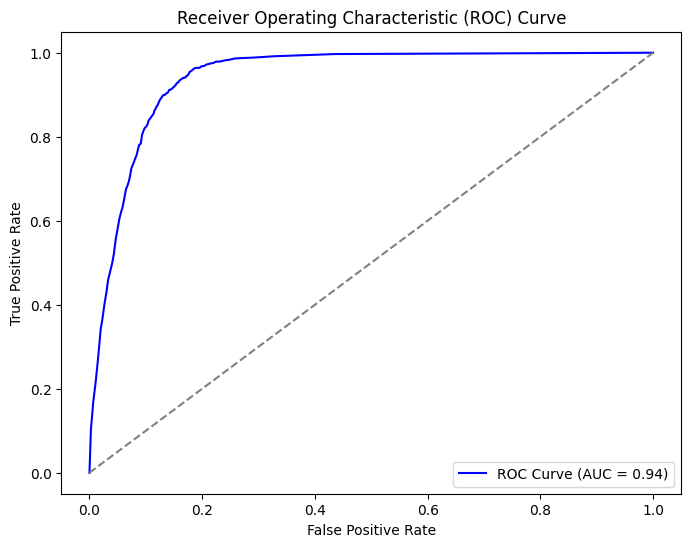

In [47]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Best Model Feature Selection**

In [49]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

best_model=xgb_clf.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]


In [50]:
feature_importance=best_model.feature_importances_
gbt_fi_df=pd.DataFrame({"Feature" : X.columns, "Importance": feature_importance})
gbt_fi_df=gbt_fi_df.sort_values(by="Importance",ascending=False)
gbt_fi_df

,Feature,Importance
10,duration,0.226015
16,cons.conf.idx,0.171215
17,emp.var.rate*nr.employed*euribor3m,0.157420
12,pdays,0.072975
4,default,0.050614
14,poutcome,0.046407
8,month,0.041222
15,cons.price.idx,0.024141
7,contact,0.023877
0,age,0.023126


In [51]:
Selected_Features=list(gbt_fi_df[gbt_fi_df["Importance"]>0.03].Feature)

In [52]:
Selected_Features.append("y")

In [54]:
df_new=df[Selected_Features]
df_new.head()

,duration,cons.conf.idx,emp.var.rate*nr.employed*euribor3m,pdays,default,poutcome,month,y
0,261.0,-36.4,27733.9557,0.0,1.0,1.0,6.0,0.0
1,149.0,-36.4,27733.9557,0.0,0.0,1.0,6.0,0.0
2,226.0,-36.4,27733.9557,0.0,1.0,1.0,6.0,0.0
3,151.0,-36.4,27733.9557,0.0,1.0,1.0,6.0,0.0
4,307.0,-36.4,27733.9557,0.0,1.0,1.0,6.0,0.0


In [55]:
X=df_new.drop("y",axis=1)
y=df_new["y"]

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [57]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6094 1197]
 [  48  896]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      7291
         1.0       0.43      0.95      0.59       944

    accuracy                           0.85      8235
   macro avg       0.71      0.89      0.75      8235
weighted avg       0.93      0.85      0.87      8235


ROC AUC Score: 0.95


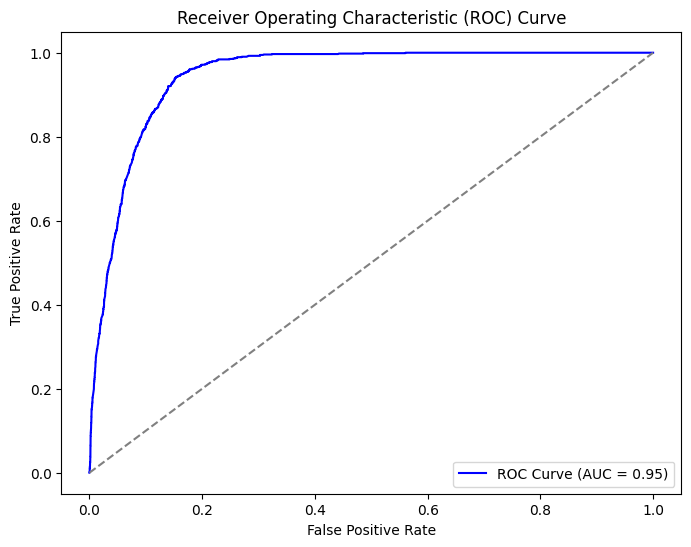

In [58]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
